# Analyse BlueSeis BSPF Events

With pressure sensor parascientific and new sensor 

In [3]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from andbro__savefig import __savefig
from obspy.clients.fdsn import Client

## Configurations

In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [5]:
config = {}

## specify coordinates of station
config['BSPF_lon'] = np.array([-116.455439])
config['BSPF_lat'] = np.array([33.610643])

## first region specified
config['minlatitude'] = 31
config['maxlatitude'] = 35
config['minlongitude'] = -119
config['maxlongitude'] = -114

config['eventfile'] = "BSPF_catalog"

## extended region specified
# config['minlatitude'] = 31 -2
# config['maxlatitude'] = 35 +2
# config['minlongitude'] = -119 -2
# config['maxlongitude'] = -114 +2
# config['eventfile'] = "BSPF_catalog_extended"

# config['minmagnitude'] = 2.5

config['tbeg'] = obs.UTCDateTime("2022-10-01")
config['tend'] = obs.UTCDateTime("2023-10-01")  ## "2023-05-31"


config['trigger'] = data_path+"BSPF/trigger/"

config['outpath'] = data_path+"BSPF/data/catalogs/"
# config['outpath'] = "./"

config['outpath_figs'] = data_path+"BSPF/figures/"

## adjust eventfile name
config['eventfile'] += f"_{str(config['tbeg'].date).replace('-','')}"
config['eventfile'] += f"_{str(config['tend'].date).replace('-','')}"

config['str_dates'] = f"{str(config['tbeg'].date).replace('-','')}_{str(config['tend'].date).replace('-','')}"

In [6]:
from functions.catalog_to_dataframe import __catalog_to_dataframe

In [7]:
def __export_new_events(config, events_old, events):

    ## combine new and old catalog
    tmp = pd.concat([__cat_to_df(events_old), __cat_to_df(events)]).reset_index(drop=False)
    ## remove duplicates
    df = tmp.drop_duplicates(subset=['index'], keep=False)
    ## sort and set index
    df = df.sort_index(ascending=False)
    df.set_index('index', inplace=True, drop=True)

    ## export new events to pickle file
    print(f" -> export new events: {config['outpath']}new_events.pkl")
    df.to_pickle(config['outpath']+"new_events.pkl")

    del tmp, df

In [8]:
def __add_distances_and_backazimuth(config, df):

    from obspy.geodetics.base import gps2dist_azimuth

    dist = np.zeros(len(df))
    baz = np.zeros(len(df))


    for ii, ev in enumerate(df.index):
        try:
            dist[ii], az, baz[ii] = gps2dist_azimuth(config['BSPF_lat'], config['BSPF_lon'],
                                                     df.latitude[ii], df.longitude[ii],
                                                     a=6378137.0, f=0.0033528106647474805
                                                     )
        except:
            print(" -> failed to compute!")

    df['backazimuth'] = baz
    df['distances_km'] = dist/1000

    return df

## Get Events

In [9]:
client = Client("USGS")

## events - all in area and time period
events_all = client.get_events(minlatitude=config['minlatitude'], maxlatitude=config['maxlatitude'],
                               minlongitude=config['minlongitude'], maxlongitude=config['maxlongitude'],
                               starttime=config['tbeg'], endtime=config['tend'],
                               )

In [10]:
print(f" -> storing: {config['outpath']}{config['eventfile']}_all.xml")
events_all.write(config['outpath']+config['eventfile']+"_all.xml", format="QUAKEML")

 -> storing: /import/kilauea-data/BSPF/data/catalogs/BSPF_catalog_20221001_20231001_all.xml


/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/obspy/io/quakeml/core.py:1112: UserWarning: 'quakeml:earthquake.usgs.gov/fdsnws/event/1/query?starttime=2022-10-01T00%3A00%3A00.000000&endtime=2023-10-01T00%3A00%3A00.000000&minlatitude=31.0&maxlatitude=35.0&minlongitude=-119.0&maxlongitude=-114.0' is not a valid QuakeML URI. It will be in the final file but note that the file will not be a valid QuakeML file.
  warnings.warn(msg % obj.id)


In [11]:
# ## events smaller than 2.0
# events_1 = client.get_events(minlatitude=config['minlatitude'], maxlatitude=config['maxlatitude'],
#                              minlongitude=config['minlongitude'], maxlongitude=config['maxlongitude'],
#                              starttime=config['tbeg'],
#                              endtime=config['tend'],
#                              maxmagnitude=2.0,
#                             )

# ## events between 2.0 and 3.0 within distance 0.5 degrees
# events_2 = client.get_events(
#                              latitude=config['BSPF_lat'], longitude=config['BSPF_lon'],
#                              starttime=config['tbeg'],
#                              endtime=config['tend'],
#                              minmagnitude=2.0,
#                              maxmagnitude=3.0,
#                              maxradius=0.5,
#                             )

# ## events between 2.0 and 3.0 within distance 2.0 degrees
# events_3 = client.get_events(
#                              latitude=config['BSPF_lat'], longitude=config['BSPF_lon'],
#                              starttime=config['tbeg'],
#                              endtime=config['tend'],
#                              minmagnitude=3.0,
#                              maxmagnitude=5.0,
#                              maxradius=5.0,
#                             )

# ## events larger than 5.0 
# events_4 = events_all.filter("magnitude > 5.0")


# ## join specified event catalogs together
# events = events_2 + events_3 + events_4

# events.plot(projection="local");

# print(f" -> storing: {config['outpath']}{config['eventfile']}_filtered.xml")
# events.write(config['outpath']+config['eventfile']+"_filtered.xml", format="QUAKEML")

### converting to dataframe

In [12]:
## convert catalog object to data frame
# events_df = __catalog_to_dataframe(events)
events_all_df = __catalog_to_dataframe(events_all)

### add distances and backazimuth

In [13]:
## add epicentral distances
# __add_distances_and_backazimuth(config, events_df)
__add_distances_and_backazimuth(config, events_all_df)

/tmp/ipykernel_541476/1780518785.py:11: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  dist[ii], az, baz[ii] = gps2dist_azimuth(config['BSPF_lat'], config['BSPF_lon'],


,latitude,longitude,depth,magnitude,type,backazimuth,distances_km
2023-09-30 21:51:17.380,34.208833,-117.577833,6690.0,1.90,ml,122.273325,123.194995
2023-09-30 20:56:33.150,33.021333,-116.349500,10310.0,0.90,ml,351.446138,66.100648
2023-09-30 20:31:25.870,33.488500,-116.756333,7090.0,0.89,ml,64.052484,31.054683
2023-09-30 19:54:01.920,32.710167,-115.560500,15230.0,1.72,ml,320.350845,130.165224
2023-09-30 15:57:35.410,32.731167,-115.555667,12590.0,2.05,ml,319.536516,128.674217
...,...,...,...,...,...,...,...
2022-10-01 05:52:50.880,34.192500,-116.824333,6870.0,1.19,ml,152.033462,73.003543
2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,19.684030,14.252022
2022-10-01 04:30:50.050,34.657667,-116.335167,3860.0,1.33,ml,185.490185,116.669525
2022-10-01 04:06:52.340,34.236000,-118.594500,2850.0,0.88,ml,108.726355,209.598906


### store catalogs

In [14]:
## write data frame as pickle file
# events_df.to_pickle(config['outpath']+config['eventfile']+".pkl")
events_all_df.to_pickle(config['outpath']+config['eventfile']+"_all.pkl")

In [15]:
config['outpath']+config['eventfile']+"_all.pkl"

'/import/kilauea-data/BSPF/data/catalogs/BSPF_catalog_20221001_20231001_all.pkl'

## Request Focal Mechanisms

In [16]:
from functions.request_CMT_events import __request_CMT_events

# !rm /import/kilauea-data/BSPF/data/catalogs/gcmt_solutions_20221001_20230930.xml

__request_CMT_events(starttime=config['tbeg'], endtime=config['tend'], outtype="QUAKEML", outfile=config['outpath']+f"gcmt_solutions_{config['str_dates']}.xml")

# cgmt = obs.read_events(config['outpath']+'gcmt_solutions_{config['str_dates']}.xml')

 -> store catalog as: /import/kilauea-data/BSPF/data/catalogs/gcmt_solutions_20221001_20231001.xml


## Plot Event Timeline

In [17]:
events_all_df = events_all_df.rename_axis('timestamp').reset_index()
events_all_df['seconds'] = [abs((events_all_df.timestamp.min()-tt).total_seconds()) for tt in events_all_df.timestamp]
events_all_df

# events_df = events_df.rename_axis('timestamp').reset_index()
# events_df['seconds'] = [abs((events_df.timestamp.min()-tt).total_seconds()) for tt in events_df.timestamp]
# events_df

,timestamp,latitude,longitude,depth,magnitude,type,backazimuth,distances_km,seconds
0,2023-09-30 21:51:17.380,34.208833,-117.577833,6690.0,1.90,ml,122.273325,123.194995,31527762.95
1,2023-09-30 20:56:33.150,33.021333,-116.349500,10310.0,0.90,ml,351.446138,66.100648,31524478.72
2,2023-09-30 20:31:25.870,33.488500,-116.756333,7090.0,0.89,ml,64.052484,31.054683,31522971.44
3,2023-09-30 19:54:01.920,32.710167,-115.560500,15230.0,1.72,ml,320.350845,130.165224,31520727.49
4,2023-09-30 15:57:35.410,32.731167,-115.555667,12590.0,2.05,ml,319.536516,128.674217,31506540.98
...,...,...,...,...,...,...,...,...,...
10836,2022-10-01 05:52:50.880,34.192500,-116.824333,6870.0,1.19,ml,152.033462,73.003543,20656.45
10837,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,19.684030,14.252022,19656.81
10838,2022-10-01 04:30:50.050,34.657667,-116.335167,3860.0,1.33,ml,185.490185,116.669525,15735.62
10839,2022-10-01 04:06:52.340,34.236000,-118.594500,2850.0,0.88,ml,108.726355,209.598906,14297.91


## Plots

In [18]:
def __plot_timeline(catalog_all_df):

    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    cax = ax.scatter(catalog_all_df.timestamp, catalog_all_df.distances_km, s=4**catalog_all_df.magnitude, 
                     c=catalog_all_df.magnitude, alpha=0.6, cmap='viridis')


    cbar = plt.colorbar(cax, ax=ax, pad=0.01)
    cbar.set_label("Magnitude", fontsize=14)

    ax.set_ylim(bottom=0)
    ax.set_ylabel("Distance (km)", fontsize=14)

    ax.grid(ls=":", zorder=-1)

#     ax.set_xlim(events_all_df.timestamp.min().date(), events_all_df.timestamp.max().date())
    ax.set_xlim(config['tbeg']-4*86400, config['tend']+4*86400)

#     ax.set_title(f"Events={len(catalog_df)}")
    ax.text(config['tend']-40*86400, catalog_all_df.distances_km.max(), f"Events={len(catalog_all_df)}")

    plt.show();
    return fig

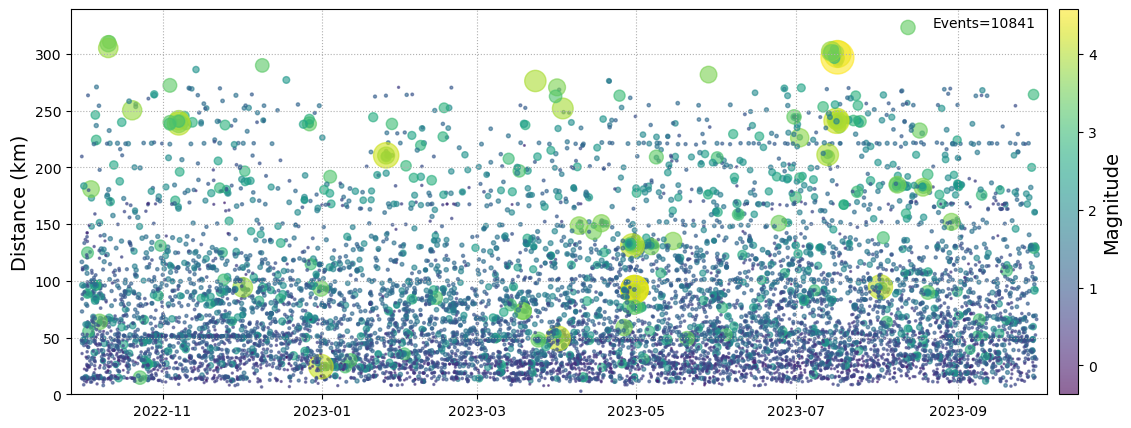

In [19]:
fig = __plot_timeline(events_all_df)

In [20]:
fig.savefig(config['outpath_figs']+f"Plot_timeline_{config['eventfile']}_{config['str_dates']}_all.png", dpi=200, bbox_inches="tight", pad_inches=0.05)